# Import Required Libraries for All Steps

In [1]:
# Import the problem formulation
# Problem formulation name is called problem_formulation_2
from problem_formulation_2 import get_model_for_problem_formulation

ModuleNotFoundError: No module named 'dike_model_function'

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
# import EMA library
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)


from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, perform_experiments, ema_logging, ScalarOutcome)
from ema_workbench.em_framework.samplers import sample_uncertainties, sample_levers
#from ema_workbench.util import ema_logginghyperv
from ema_workbench import save_results
from ema_workbench import load_results
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.analysis import feature_scoring, prim
#from ema_workbench.analysis.scenario_discovery_util import CLASSIFICATION, REGRESSION
from ema_workbench.analysis import dimensional_stacking
import numpy.lib.recfunctions as rf
from SALib.analyze import sobol

import statsmodels.api as sm
import itertools
from math import pi

C:\ProgramData\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap_external.py:426: ImportWarning: Not importing directory C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap_external.py:426: ImportWarning: Not importing directory c:\programdata\anaconda3\lib\site-packages\mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


ModuleNotFoundError: No module named 'SALib'

In [4]:
import matplotlib.pyplot as plt

In [15]:
from SALib.sample import saltelli

In [16]:
import scipy

In [5]:
%matplotlib inline

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

dike_model = get_model_for_problem_formulation(4)

NameError: name 'get_model_for_problem_formulation' is not defined

# SOBOL Sensitivity Analysis with No Policy

In [17]:
# Initialization for SALib
uncertainty_problem = get_SALib_problem(dike_model.uncertainties)

In [20]:
# Defined No Policy
zero_policy = {'DikeIncrease': 0, 'DaysToThreat': 0, 'RfR': 0}
pol0 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split('_')
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy('Policy 0', **pol0)

In [22]:
# Setting number of random scenarios sample
n_uncertainties_sobol = 500

In [23]:
# Running optimization algorithm with policy0 as reference policy to check distribution of the scenarios.
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_sobol = evaluator.perform_experiments(n_uncertainties_sobol, policy0, uncertainty_sampling=SOBOL, levers_sampling=SOBOL)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 18000 scenarios * 1 policies * 1 model(s) = 18000 experiments
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 5400 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12600 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 16200 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [24]:
# Results tuple unpacking
experiments_sobol, outcomes_sobol = results_sobol

In [25]:
# Slicing dataframe to be inputted in sobol.analyze function
all_costs_sobol = outcomes_sobol['All Costs']
dike_investment_sobol = outcomes_sobol['Dike Investment Costs']
expected_damage_sobol = outcomes_sobol['Expected Annual Damage']
evacuation_costs_sobol = outcomes_sobol['Expected Evacuation Costs']
RfR_costs_sobol = outcomes_sobol['RfR Total Costs']
investment_costs_sobol = outcomes_sobol['Total Investment Costs']
number_death_sobol = outcomes_sobol['Total Number of Deaths']

# perform sobol.analyze functionality
# Some of variables are deactivated (dike investment, RfR, etc.) because no policy will generate 0 result for those variables

all_costs_scores = sobol.analyze(uncertainty_problem, all_costs_sobol, calc_second_order=True, print_to_console=False)
#dike_investment_sobol = sobol.analyze(uncertainty_problem, dike_investment_sobol, calc_second_order=True, print_to_console=False)
expected_damage_scores = sobol.analyze(uncertainty_problem, expected_damage_sobol, calc_second_order=True, print_to_console=False)
#RfR_costs_sobol = sobol.analyze(uncertainty_problem, RfR_costs_sobol, calc_second_order=True, print_to_console=False)
#evacuation_costs_sobol = sobol.analyze(uncertainty_problem, evacuation_costs_sobol, calc_second_order=True, print_to_console=False)
#investment_costs_sobol = sobol.analyze(uncertainty_problem, investment_costs_sobol, calc_second_order=True, print_to_console=False)
number_death_scores = sobol.analyze(uncertainty_problem, number_death_sobol, calc_second_order=True, print_to_console=False)

In [26]:
# reference in evaluator is for reference to scenario or policy

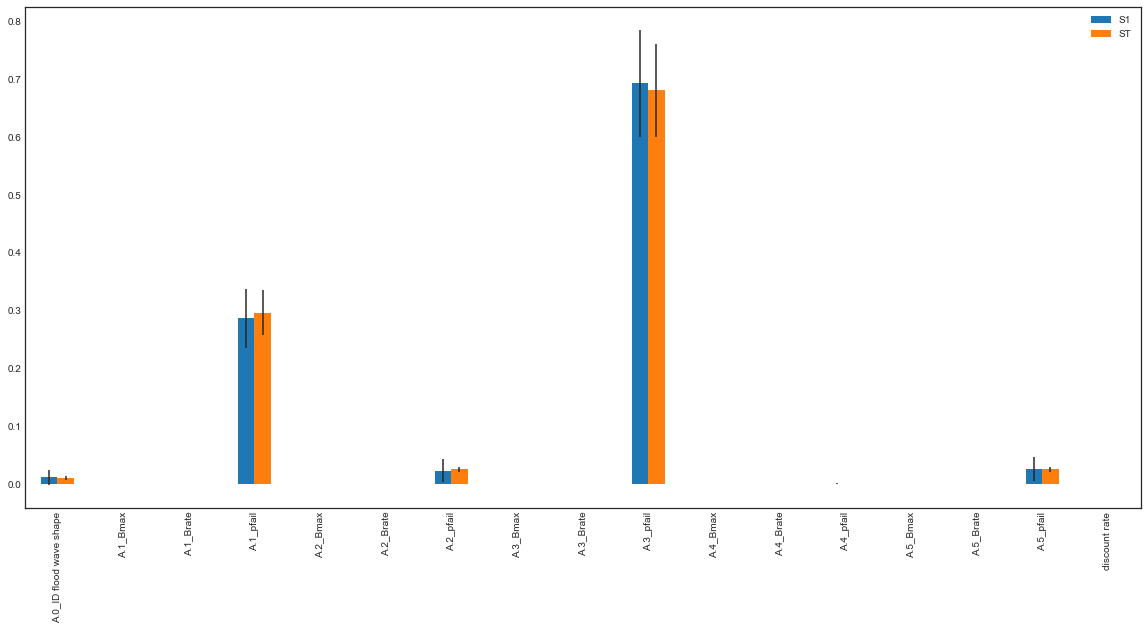

In [27]:
# Plot S1 and ST bar chart.
def plot_scores(scores):
    scores_filtered = {k:scores[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=uncertainty_problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(20,12)
    fig.subplots_adjust(bottom=0.3)
    return fig

plot_scores(number_death_scores)
plt.show()

In [28]:
# Prepare dataframe for next visualization
allcosts_filtered_sobol = {k:all_costs_scores[k] for k in ['ST','ST_conf','S1','S1_conf']}
numberdeath_filtered_sobol = {k:number_death_scores[k] for k in ['ST','ST_conf','S1','S1_conf']}
expecteddamage_filtered_sobol = {k:expected_damage_scores[k] for k in ['ST','ST_conf','S1','S1_conf']}

Si_allcosts_df_sobol = pd.DataFrame(allcosts_filtered_sobol, index=uncertainty_problem['names'])
Si_numberdeath_df_sobol = pd.DataFrame(numberdeath_filtered_sobol, index=uncertainty_problem['names'])
Si_expecteddamage_df_sobol = pd.DataFrame(expecteddamage_filtered_sobol, index=uncertainty_problem['names'])

In [33]:
new_df_uncertainty = pd.DataFrame(data=None, index=Si_expecteddamage_df_sobol.index, columns=['All Costs','Number of Death','Expected Annual Damage'])

In [34]:
new_df_uncertainty['All Costs'] = Si_allcosts_df_sobol[['ST']]
new_df_uncertainty['Number of Death'] = Si_numberdeath_df_sobol[['ST']]
new_df_uncertainty['Expected Annual Damage'] = Si_expecteddamage_df_sobol[['ST']]

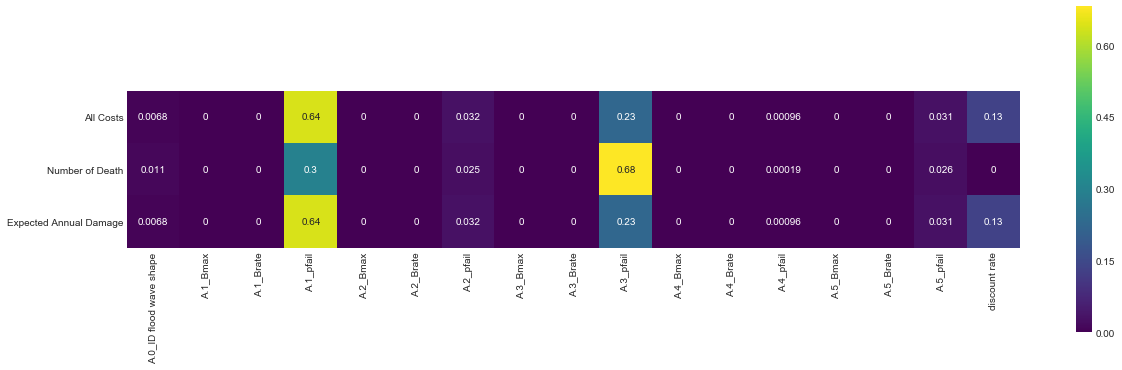

In [35]:
ax = sns.heatmap(new_df_uncertainty.T, cmap='viridis', annot=True)

ax.set_aspect('equal')
fig = plt.gcf()
fig.set_size_inches(20,6)

plt.yticks(rotation=0)

plt.show()

# Policy Sensitivity Analysis Based on Reference Scenario from Research Paper

In this part, some value according to research paper will be used as defined below. The detailed explanation is explained on the report. **The goal is to check sensitivity value difference between this analysis and latter stage of analysis where we use worst case scenario as reference scenario.**

In [36]:
# levers problem initialization
levers_problem = get_SALib_problem(dike_model.levers)

In [37]:
# checking the uncertainties
list(dike_model.uncertainties)

[RealParameter('A.1_Bmax', 5, 400),
 RealParameter('A.1_pfail', 0, 1),
 CategoricalParameter('A.1_Brate', [0, 1, 2]),
 RealParameter('A.2_Bmax', 5, 400),
 RealParameter('A.2_pfail', 0, 1),
 CategoricalParameter('A.2_Brate', [0, 1, 2]),
 RealParameter('A.3_Bmax', 5, 400),
 RealParameter('A.3_pfail', 0, 1),
 CategoricalParameter('A.3_Brate', [0, 1, 2]),
 RealParameter('A.4_Bmax', 5, 400),
 RealParameter('A.4_pfail', 0, 1),
 CategoricalParameter('A.4_Brate', [0, 1, 2]),
 RealParameter('A.5_Bmax', 5, 400),
 RealParameter('A.5_pfail', 0, 1),
 CategoricalParameter('A.5_Brate', [0, 1, 2]),
 CategoricalParameter('discount rate', [0, 1, 2, 3]),
 IntegerParameter('A.0_ID flood wave shape', 0, 132)]

In [38]:
# Fix the scenario to understand the sensitivity of decision levers
# Assumption of the scenario as follows:
reference_values = {'Bmax': 300, 'Brate': 1.5, 'pfail': 0.7, 
                        'discount rate': 3.5,
                        'ID flood wave shape': 98}
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})
                                
    else:
        scen1.update({key.name: reference_values[name_split[1]]})
        
ref_scenario = Scenario('reference', **scen1)

In [39]:
# Setting number of levers samples
n_levers_sobol = 500

In [40]:
# Perform experiments using SOBOL sampling methods
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_sobol_levers = evaluator.perform_experiments(ref_scenario, n_levers_sobol, uncertainty_sampling=SOBOL, levers_sampling=SOBOL)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 12000 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [41]:
# results unpacking
experiments_sobol_levers, outcomes_sobol_levers = results_sobol_levers

In [42]:
# Prepare dataframe to be inputted on sobol.analyze.
all_costs_sobol_levers = outcomes_sobol_levers['All Costs']
dike_investment_sobol_levers = outcomes_sobol_levers['Dike Investment Costs']
expected_damage_sobol_levers = outcomes_sobol_levers['Expected Annual Damage']
evacuation_costs_sobol_levers = outcomes_sobol_levers['Expected Evacuation Costs']
RfR_costs_sobol_levers = outcomes_sobol_levers['RfR Total Costs']
investment_costs_sobol_levers = outcomes_sobol_levers['Total Investment Costs']
number_death_sobol_levers = outcomes_sobol_levers['Total Number of Deaths']

# Perform sobol analysis
all_costs_scores_levers = sobol.analyze(levers_problem, all_costs_sobol_levers, calc_second_order=True, print_to_console=False)
dike_investment_scores_levers = sobol.analyze(levers_problem, dike_investment_sobol_levers, calc_second_order=True, print_to_console=False)
expected_damage_scores_levers = sobol.analyze(levers_problem, expected_damage_sobol_levers, calc_second_order=True, print_to_console=False)
RfR_costs_scores_levers = sobol.analyze(levers_problem, RfR_costs_sobol_levers, calc_second_order=True, print_to_console=False)
evacuation_costs_scores_levers = sobol.analyze(levers_problem, evacuation_costs_sobol_levers, calc_second_order=True, print_to_console=False)
investment_costs_scores_levers = sobol.analyze(levers_problem, investment_costs_sobol_levers, calc_second_order=True, print_to_console=False)
number_death_scores_levers = sobol.analyze(levers_problem, number_death_sobol_levers, calc_second_order=True, print_to_console=False)

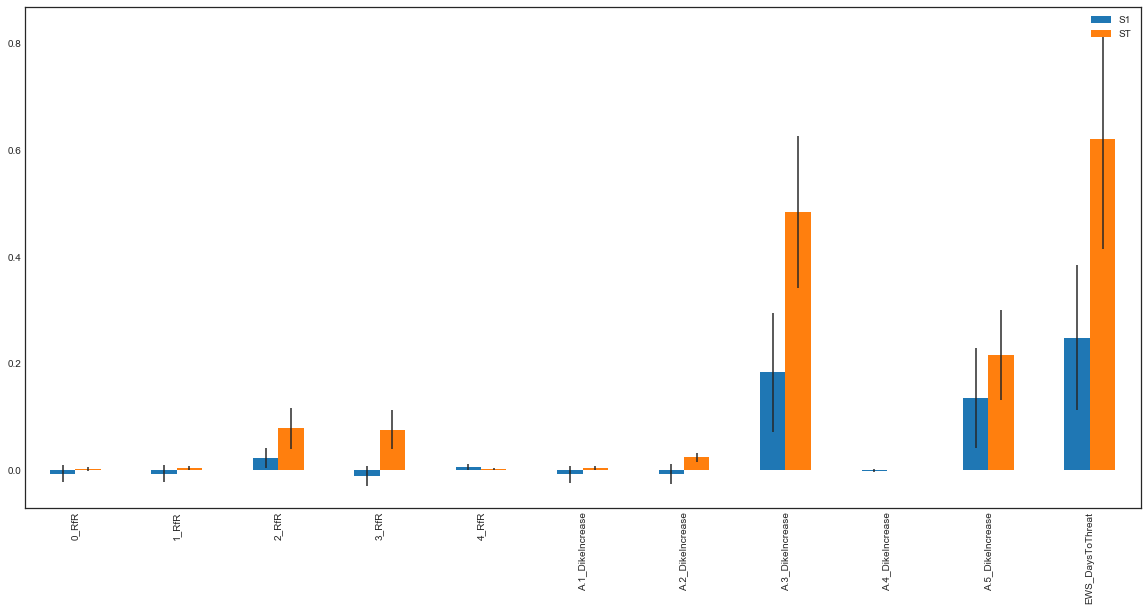

In [43]:
# Plot S1 and ST in a barchart.
def plot_scores_sobol(scores):
    scores_filtered = {k:scores[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=levers_problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(20,12)
    fig.subplots_adjust(bottom=0.3)
    return fig

plot_scores_sobol(number_death_scores_levers)
plt.show()

In [44]:
# Unpack variables into dictionary
levers_allcosts_filtered_sobol = {k:all_costs_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_numberdeath_filtered_sobol = {k:number_death_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_expecteddamage_filtered_sobol = {k:expected_damage_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_dikeinv_filtered_sobol = {k:dike_investment_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_RfRcosts_filtered_sobol = {k:RfR_costs_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_evacuation_filtered_sobol = {k:evacuation_costs_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_investment_filtered_sobol = {k:investment_costs_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}

In [46]:
# convert the dictionary to dataframe as a data for next visualization
Si_levers_allcosts_df_sobol = pd.DataFrame(levers_allcosts_filtered_sobol, index=levers_problem['names'])
Si_levers_numberdeath_df_sobol = pd.DataFrame(levers_numberdeath_filtered_sobol, index=levers_problem['names'])
Si_levers_expecteddamage_df_sobol = pd.DataFrame(levers_expecteddamage_filtered_sobol, index=levers_problem['names'])
Si_levers_dikeinv_df_sobol = pd.DataFrame(levers_dikeinv_filtered_sobol, index=levers_problem['names'])
Si_levers_RfRcosts_df_sobol = pd.DataFrame(levers_RfRcosts_filtered_sobol, index=levers_problem['names'])
Si_levers_evacuation_df_sobol = pd.DataFrame(levers_evacuation_filtered_sobol, index=levers_problem['names'])
Si_levers_investment_df_sobol = pd.DataFrame(levers_investment_filtered_sobol, index=levers_problem['names'])

In [47]:
new_df_levers = pd.DataFrame(data=None, index=Si_levers_expecteddamage_df_sobol.index, columns=['All Costs','Number of Death','Expected Annual Damage','Dike Investment Costs', 'RfR Costs', 'Evacuation Costs', 'Total Investment Costs'])

In [48]:
new_df_levers

,All Costs,Number of Death,Expected Annual Damage,Dike Investment Costs,RfR Costs,Evacuation Costs,Total Investment Costs
0_RfR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_RfR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_RfR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_RfR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4_RfR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.1_DikeIncrease,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.2_DikeIncrease,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.3_DikeIncrease,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.4_DikeIncrease,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.5_DikeIncrease,NaN,NaN,NaN,NaN,NaN,NaN,NaN


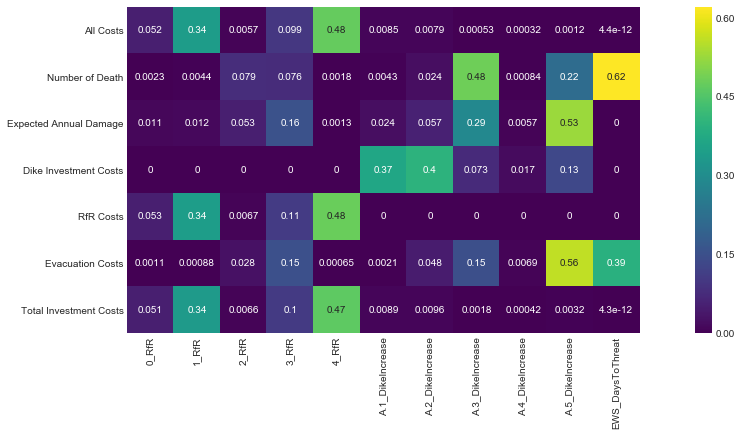

In [49]:
# Plot the heatmap based on sensitivity value
new_df_levers['All Costs'] = Si_levers_allcosts_df_sobol[['ST']]
new_df_levers['Number of Death'] = Si_levers_numberdeath_df_sobol[['ST']]
new_df_levers['Expected Annual Damage'] = Si_levers_expecteddamage_df_sobol[['ST']]
new_df_levers['Dike Investment Costs'] = Si_levers_dikeinv_df_sobol[['ST']]
new_df_levers['RfR Costs'] = Si_levers_RfRcosts_df_sobol[['ST']]
new_df_levers['Evacuation Costs'] = Si_levers_evacuation_df_sobol[['ST']]
new_df_levers['Total Investment Costs'] = Si_levers_investment_df_sobol[['ST']]

ax = sns.heatmap(new_df_levers.T, cmap='viridis', annot=True)

ax.set_aspect('equal')
fig = plt.gcf()
fig.set_size_inches(20,6)

plt.yticks(rotation=0)

plt.show()

In [50]:
# Prepare variables to plot correlation analysis
levers_allcosts_filtered_sobol_2 = {k:all_costs_scores_levers[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_numberdeath_filtered_sobol_2 = {k:number_death_scores_levers[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_expecteddamage_filtered_sobol_2 = {k:expected_damage_scores_levers[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_dikeinv_filtered_sobol_2 = {k:dike_investment_scores_levers[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_RfRcosts_filtered_sobol_2 = {k:RfR_costs_scores_levers[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_evacuation_filtered_sobol_2 = {k:evacuation_costs_scores_levers[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_investment_filtered_sobol_2 = {k:investment_costs_scores_levers[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}

C:\Users\andreas.yunus\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


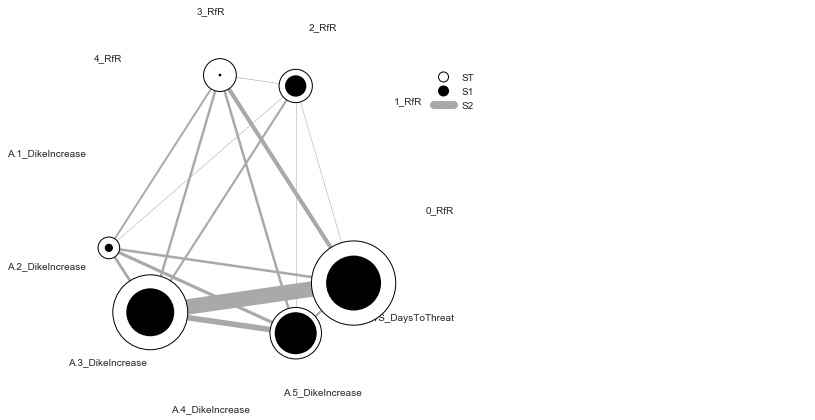

In [51]:
def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=levers_problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=levers_problem['names'],
                      columns=levers_problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = levers_problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)
    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(ymax=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.ix[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(levers_numberdeath_filtered_sobol_2, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

plt.show()

C:\Users\andreas.yunus\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


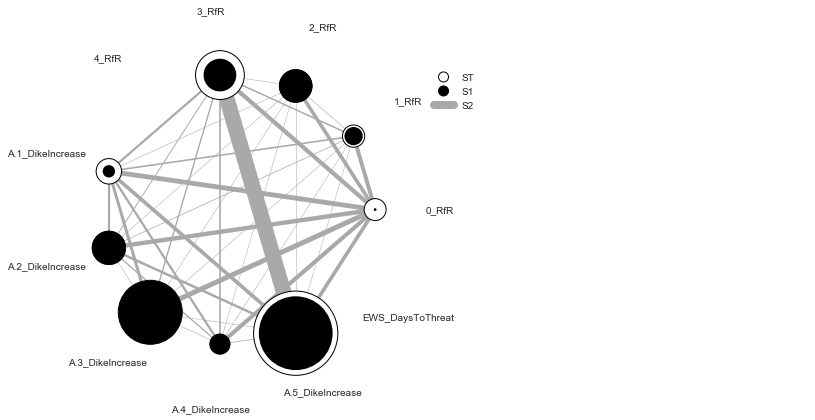

In [52]:
fig_2 = plot_sobol_indices(levers_expecteddamage_filtered_sobol_2, criterion='ST', threshold=0.005)
fig_2.set_size_inches(7,7)

plt.show()

In [53]:
n = 500
param_values = saltelli.sample(levers_problem, n, calc_second_order=True)

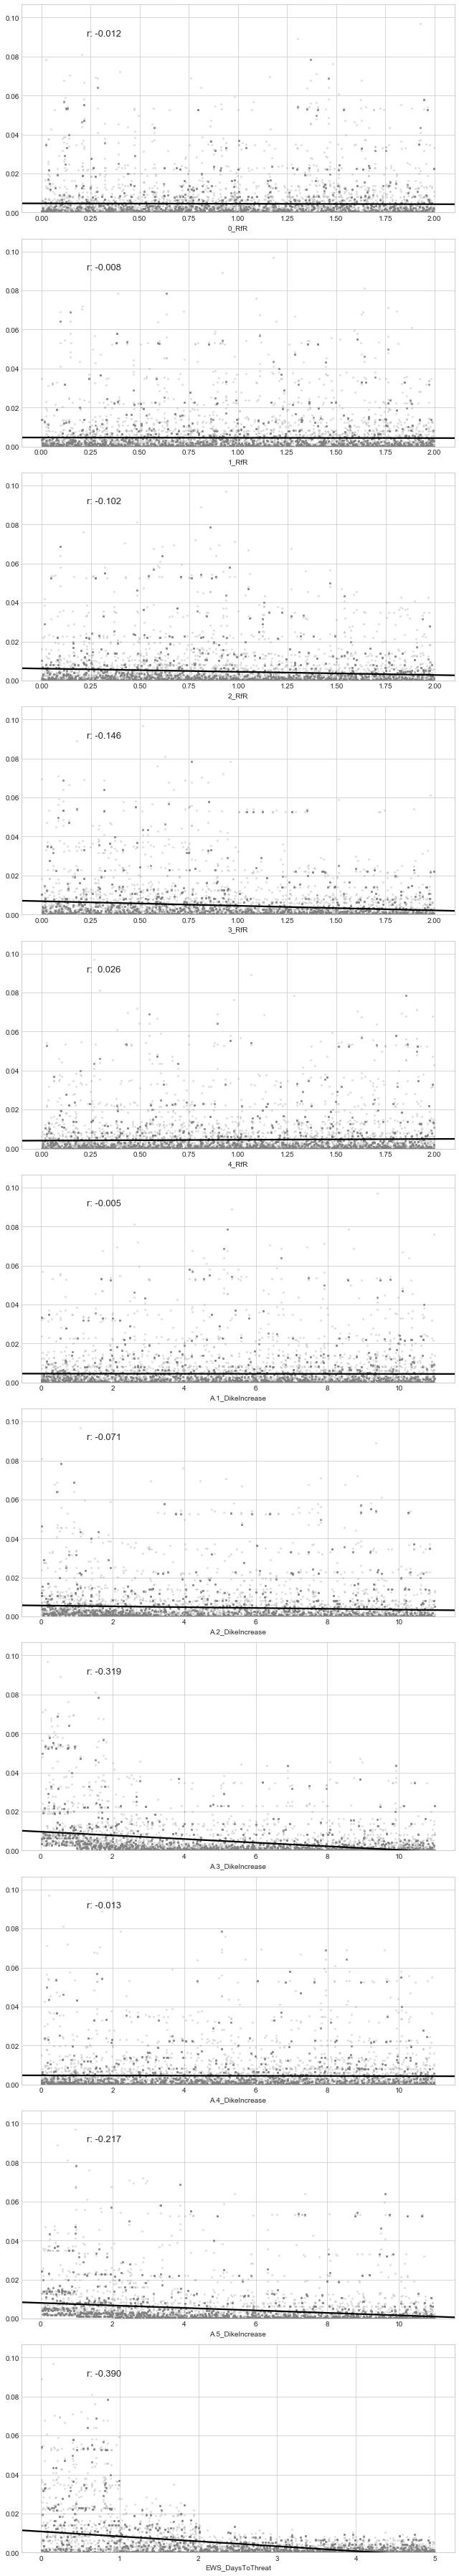

In [58]:
nrow=11
ncol=1

fig, ax = plt.subplots(nrow, ncol, sharey=True)

y = outcomes_sobol_levers['Total Number of Deaths']

for i, a in enumerate(ax.flatten()):
    x = param_values[:,i]
    sns.regplot(x, y, ax=a, ci=None, color='k',scatter_kws={'alpha':0.2, 's':4, 'color':'gray'})
    pearson = scipy.stats.pearsonr(x, y)
    a.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction', fontsize=13)
    if divmod(i,ncol)[1]>0:
        a.get_yaxis().set_visible(False)
    a.set_xlabel(levers_problem['names'][i])
    a.set_ylim([0,1.1*np.max(y)])

fig.set_size_inches(9,50,forward=True)
plt.tight_layout()

# Worst Case Discovery

In [59]:
# Setting the direction to maximize the outcomes instead of minimize
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in dike_model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

In [60]:
dike_model.outcomes.keys()

odict_keys(['All Costs', 'Total Investment Costs', 'Expected Annual Damage', 'Total Number of Deaths', 'Dike Investment Costs', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [61]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_worst_case = evaluator.optimize(nfe=10000, searchover='uncertainties',
                                 epsilons=[1000,1000,1000,0.01,1000,1000,10]*len(dike_model.outcomes), reference = policy0)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies

In [100]:
results_worst_case_fordict = results_worst_case.iloc[:,:17]

In [101]:
results_worst_case_fordict

,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate,discount rate,A.0_ID flood wave shape
0,287.667747,0.176862,"Category('1000', 1000)",156.321766,0.015438,"Category('1000', 1000)",312.198732,0.154676,"Category('0.9', 0.9)",224.589618,0.0378,"Category('0.9', 0.9)",104.451319,0.008896,"Category('1000', 1000)","Category('1.5', 1.5)",123


In [102]:
# Worst case results
results_worst_case

,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,...,A.5_Brate,discount rate,A.0_ID flood wave shape,All Costs,Total Investment Costs,Expected Annual Damage,Total Number of Deaths,Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs
0,287.667747,0.176862,"Category('1000', 1000)",156.321766,0.015438,"Category('1000', 1000)",312.198732,0.154676,"Category('0.9', 0.9)",224.589618,...,"Category('1000', 1000)","Category('1.5', 1.5)",123,2.790330e+09,0.0,2.790330e+09,2.4905,0.0,0.0,0.0


In [103]:
results_worst_case_fordict['A.1_Brate'] = results_worst_case_fordict['A.1_Brate'][0].value
results_worst_case_fordict['A.2_Brate'] = results_worst_case_fordict['A.2_Brate'][0].value
results_worst_case_fordict['A.3_Brate'] = results_worst_case_fordict['A.3_Brate'][0].value
results_worst_case_fordict['A.4_Brate'] = results_worst_case_fordict['A.4_Brate'][0].value
results_worst_case_fordict['A.5_Brate'] = results_worst_case_fordict['A.5_Brate'][0].value
results_worst_case_fordict['discount rate'] = results_worst_case_fordict['discount rate'][0].value

In [105]:
reference_worst_case_dict = results_worst_case_fordict.to_dict('records')

In [106]:
reference_worst_case_dict = reference_worst_case_dict[0]

In [107]:
ref_scenario_worst = Scenario('reference_worst', **reference_worst_case_dict)                    # !!!!!!!

In [108]:
ref_scenario_worst

{'A.1_Bmax': 287.6677474388988, 'A.1_pfail': 0.17686240666354947, 'A.1_Brate': 1000.0, 'A.2_Bmax': 156.3217657959773, 'A.2_pfail': 0.015437698957163208, 'A.2_Brate': 1000.0, 'A.3_Bmax': 312.19873198634286, 'A.3_pfail': 0.1546762468272212, 'A.3_Brate': 0.9, 'A.4_Bmax': 224.58961798234225, 'A.4_pfail': 0.037800279430313256, 'A.4_Brate': 0.9, 'A.5_Bmax': 104.45131856082365, 'A.5_pfail': 0.008895839887874128, 'A.5_Brate': 1000.0, 'discount rate': 1.5, 'A.0_ID flood wave shape': 123.0}

In [109]:
# Perform experiments with sobol sampling
n_levers_sobol_worst = 500
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_sobol_levers_worst = evaluator.perform_experiments(ref_scenario_worst, n_levers_sobol_worst, uncertainty_sampling=SOBOL, levers_sampling=SOBOL)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 12000 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Starting from this point to end of this particular section, it's similar to previous section. The difference is only the reference scenario

In [110]:
experiments_sobol_levers_worst, outcomes_sobol_levers_worst = results_sobol_levers_worst

In [111]:
all_costs_sobol_levers_worst = outcomes_sobol_levers_worst['All Costs']
dike_investment_sobol_levers_worst = outcomes_sobol_levers_worst['Dike Investment Costs']
expected_damage_sobol_levers_worst = outcomes_sobol_levers_worst['Expected Annual Damage']
evacuation_costs_sobol_levers_worst = outcomes_sobol_levers_worst['Expected Evacuation Costs']
RfR_costs_sobol_levers_worst = outcomes_sobol_levers_worst['RfR Total Costs']
investment_costs_sobol_levers_worst = outcomes_sobol_levers_worst['Total Investment Costs']
number_death_sobol_levers_worst = outcomes_sobol_levers_worst['Total Number of Deaths']

all_costs_scores_levers_worst = sobol.analyze(levers_problem, all_costs_sobol_levers_worst, calc_second_order=True, print_to_console=False)
dike_investment_scores_levers_worst = sobol.analyze(levers_problem, dike_investment_sobol_levers_worst, calc_second_order=True, print_to_console=False)
expected_damage_scores_levers_worst = sobol.analyze(levers_problem, expected_damage_sobol_levers_worst, calc_second_order=True, print_to_console=False)
RfR_costs_scores_levers_worst = sobol.analyze(levers_problem, RfR_costs_sobol_levers_worst, calc_second_order=True, print_to_console=False)
evacuation_costs_scores_levers_worst = sobol.analyze(levers_problem, evacuation_costs_sobol_levers_worst, calc_second_order=True, print_to_console=False)
investment_costs_scores_levers_worst = sobol.analyze(levers_problem, investment_costs_sobol_levers_worst, calc_second_order=True, print_to_console=False)
number_death_scores_levers_worst = sobol.analyze(levers_problem, number_death_sobol_levers_worst, calc_second_order=True, print_to_console=False)

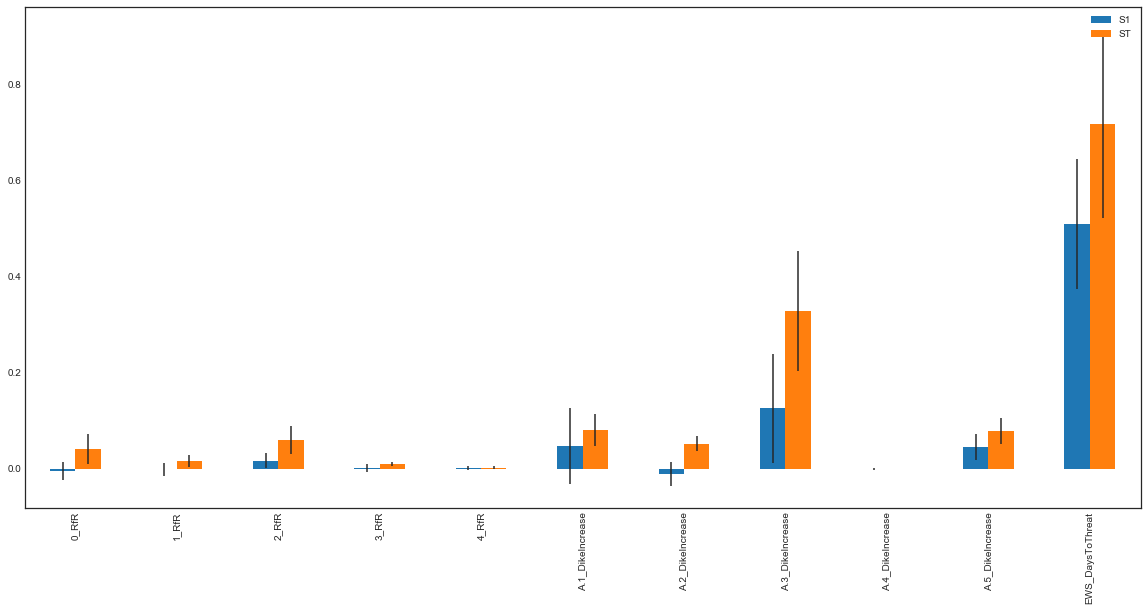

In [112]:
def plot_scores_sobol_worst(scores):
    scores_filtered = {k:scores[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=levers_problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(20,12)
    fig.subplots_adjust(bottom=0.3)
    return fig

plot_scores_sobol_worst(number_death_scores_levers_worst)
plt.show()

In [113]:
levers_allcosts_filtered_sobol_worst = {k:all_costs_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_numberdeath_filtered_sobol_worst = {k:number_death_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_expecteddamage_filtered_sobol_worst = {k:expected_damage_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_dikeinv_filtered_sobol_worst = {k:dike_investment_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_RfRcosts_filtered_sobol_worst = {k:RfR_costs_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_evacuation_filtered_sobol_worst = {k:evacuation_costs_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}
levers_investment_filtered_sobol_worst = {k:investment_costs_scores_levers[k] for k in ['ST','ST_conf','S1','S1_conf']}

Si_levers_allcosts_df_sobol_worst = pd.DataFrame(levers_allcosts_filtered_sobol_worst, index=levers_problem['names'])
Si_levers_numberdeath_df_sobol_worst = pd.DataFrame(levers_numberdeath_filtered_sobol_worst, index=levers_problem['names'])
Si_levers_expecteddamage_df_sobol_worst = pd.DataFrame(levers_expecteddamage_filtered_sobol_worst, index=levers_problem['names'])
Si_levers_dikeinv_df_sobol_worst = pd.DataFrame(levers_dikeinv_filtered_sobol_worst, index=levers_problem['names'])
Si_levers_RfRcosts_df_sobol_worst = pd.DataFrame(levers_RfRcosts_filtered_sobol_worst, index=levers_problem['names'])
Si_levers_evacuation_df_sobol_worst = pd.DataFrame(levers_evacuation_filtered_sobol_worst, index=levers_problem['names'])
Si_levers_investment_df_sobol_worst = pd.DataFrame(levers_investment_filtered_sobol_worst, index=levers_problem['names'])

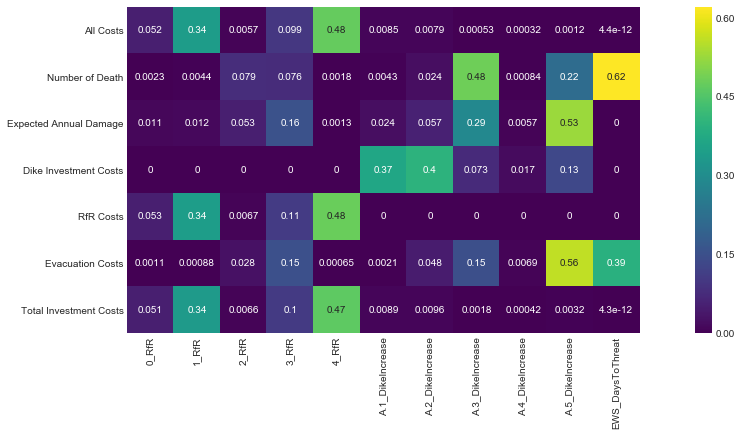

In [114]:
new_df_levers_worst = pd.DataFrame(data=None, index=Si_levers_expecteddamage_df_sobol_worst.index, columns=['All Costs','Number of Death','Expected Annual Damage','Dike Investment Costs', 'RfR Costs', 'Evacuation Costs', 'Total Investment Costs'])

new_df_levers_worst['All Costs'] = Si_levers_allcosts_df_sobol_worst[['ST']]
new_df_levers_worst['Number of Death'] = Si_levers_numberdeath_df_sobol_worst[['ST']]
new_df_levers_worst['Expected Annual Damage'] = Si_levers_expecteddamage_df_sobol_worst[['ST']]
new_df_levers_worst['Dike Investment Costs'] = Si_levers_dikeinv_df_sobol_worst[['ST']]
new_df_levers_worst['RfR Costs'] = Si_levers_RfRcosts_df_sobol_worst[['ST']]
new_df_levers_worst['Evacuation Costs'] = Si_levers_evacuation_df_sobol_worst[['ST']]
new_df_levers_worst['Total Investment Costs'] = Si_levers_investment_df_sobol_worst[['ST']]

ax = sns.heatmap(new_df_levers_worst.T, cmap='viridis', annot=True)

ax.set_aspect('equal')
fig = plt.gcf()
fig.set_size_inches(20,6)

plt.yticks(rotation=0)

plt.show()

C:\Users\andreas.yunus\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


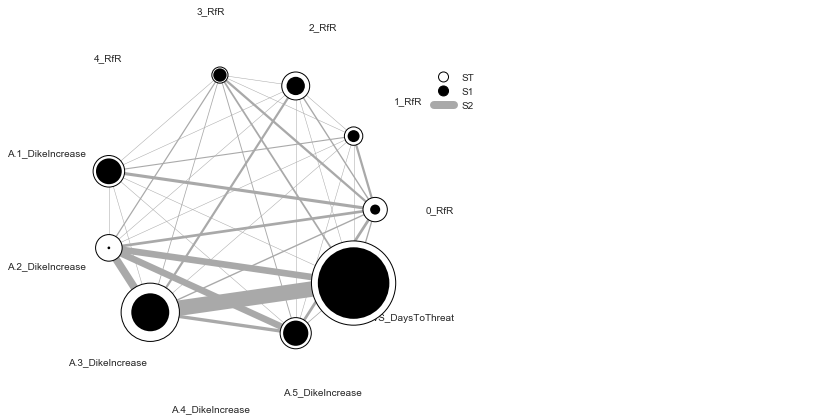

In [115]:


levers_allcosts_filtered_sobol_2_worst = {k:all_costs_scores_levers_worst[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_numberdeath_filtered_sobol_2_worst= {k:number_death_scores_levers_worst[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_expecteddamage_filtered_sobol_2_worst = {k:expected_damage_scores_levers_worst[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_dikeinv_filtered_sobol_2_worst = {k:dike_investment_scores_levers_worst[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_RfRcosts_filtered_sobol_2_worst = {k:RfR_costs_scores_levers_worst[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_evacuation_filtered_sobol_2_worst = {k:evacuation_costs_scores_levers_worst[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}
levers_investment_filtered_sobol_2_worst = {k:investment_costs_scores_levers_worst[k] for k in ['ST','ST_conf','S2','S2_conf','S1','S1_conf']}

def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=levers_problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=levers_problem['names'],
                      columns=levers_problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = levers_problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)
    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(ymax=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.ix[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(levers_numberdeath_filtered_sobol_2_worst, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

plt.show()

C:\Users\andreas.yunus\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


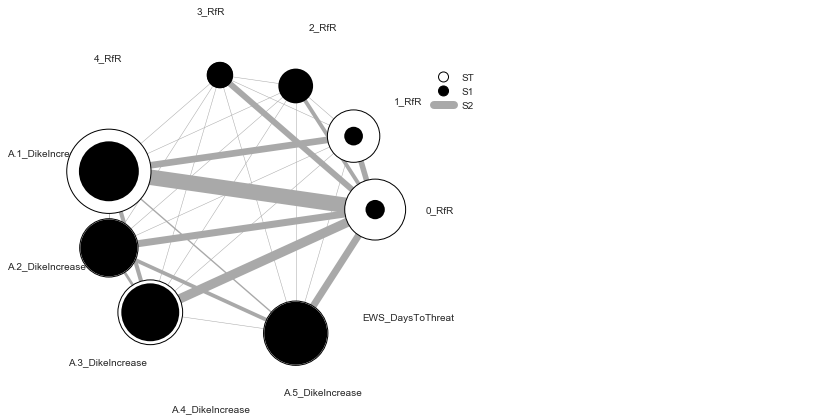

In [117]:
fig_3 = plot_sobol_indices(levers_expecteddamage_filtered_sobol_2_worst, criterion='ST', threshold=0.005)
fig_3.set_size_inches(7,7)

plt.show()

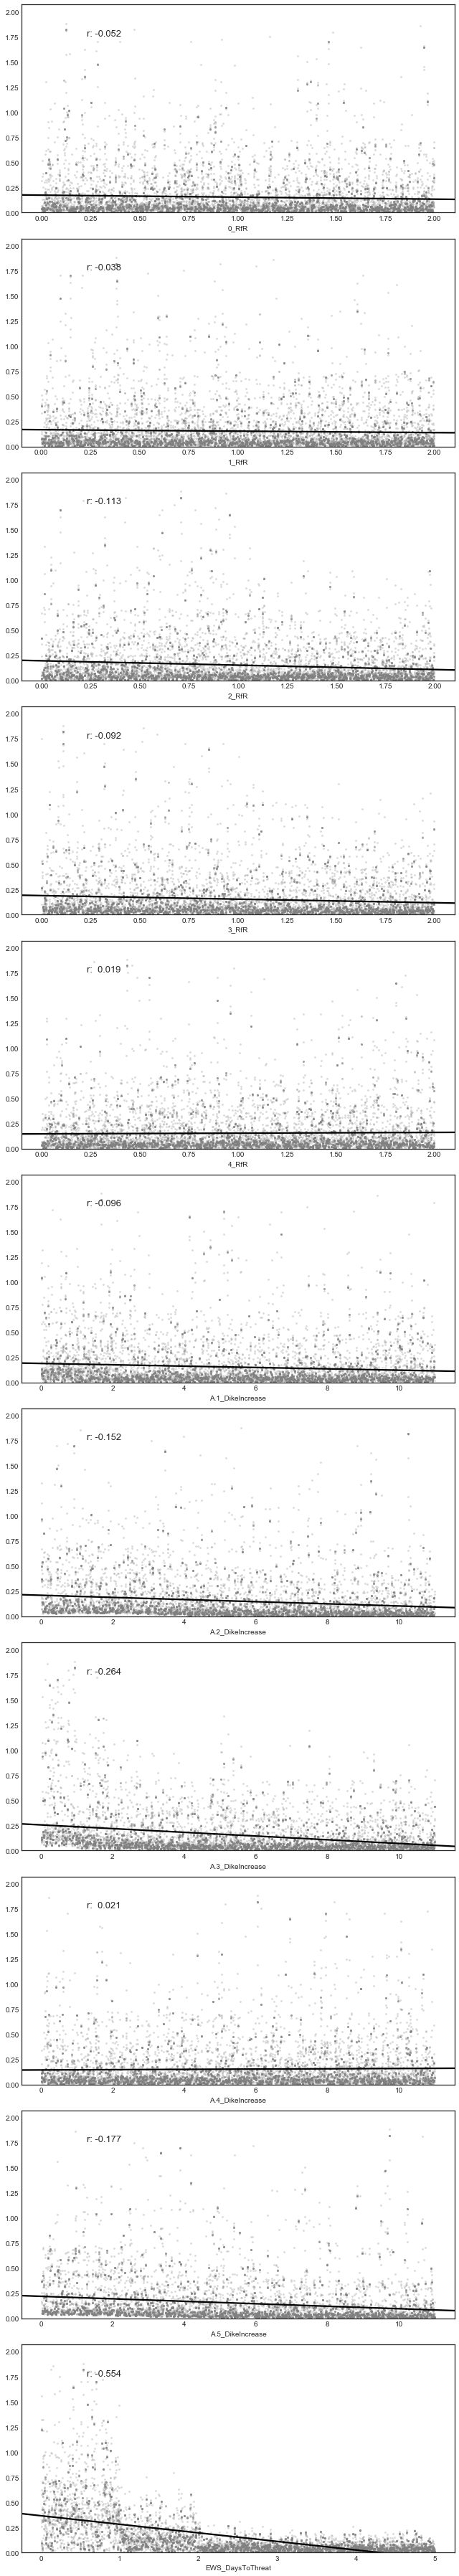

In [196]:
nrow=11
ncol=1

fig_reg, ax = plt.subplots(nrow, ncol, sharey=True)

y = outcomes_sobol_levers_worst['Total Number of Deaths']

for i, a in enumerate(ax.flatten()):
    x = param_values[:,i]
    sns.regplot(x, y, ax=a, ci=None, color='k',scatter_kws={'alpha':0.2, 's':4, 'color':'gray'})
    pearson = scipy.stats.pearsonr(x, y)
    a.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction', fontsize=13)
    if divmod(i,ncol)[1]>0:
        a.get_yaxis().set_visible(False)
    a.set_xlabel(levers_problem['names'][i])
    a.set_ylim([0,1.1*np.max(y)])

fig_reg.set_size_inches(9,50,forward=True)
plt.tight_layout()

In [197]:
fig_reg.savefig("regression_worst.PNG")

# Optimization with All Policies

In [118]:
# Import required libraries
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)

In [154]:
# Setting back the direction to minimize the outcomes
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in dike_model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = minimize
    else:
        outcome.kind = maximize

In [120]:
# Optimization without Any Constraints. MORO has constraints (later on) as extracted from MORDM.
# See pp. 1 in the Report (explanation of the sequence of methods)

In [121]:
# Perform optimization
# The input of the optimization if the worst case scebario that was found abworstove.
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_optimize_MORDM = evaluator.optimize(nfe=8000, searchover='levers',
                                 epsilons=[1000,1000,1000,0.01,1000,1000,10]*len(dike_model.outcomes), reference = ref_scenario_worst)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/8000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/8000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/8000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 298/8000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess

In [143]:
results_optimize_MORDM.to_csv("results_optimize_MORDM_1.csv")

In [132]:
results_optimize_MORDM.head()   # 585 solutions

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,All Costs,Total Investment Costs,Expected Annual Damage,Total Number of Deaths,Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs
0,10,10,5,6,10,0,1,1,0,0,1,4.965628e+08,4.637975e+08,3.276525e+07,0.011439,2.152967e+08,248500000.0,823.529306
1,8,10,10,5,2,0,1,0,0,1,2,1.125335e+09,6.701002e+08,4.552352e+08,0.052768,1.961782e+08,473900000.0,22012.341826
2,10,8,0,0,1,1,1,0,0,0,2,1.808547e+09,4.567516e+08,1.351795e+09,0.237329,1.542958e+08,302400000.0,55801.315168
3,10,8,1,9,4,1,1,0,0,0,4,1.139498e+09,4.947391e+08,6.447586e+08,0.098435,1.923033e+08,302400000.0,35741.990555
4,10,10,4,5,1,1,1,1,0,0,0,1.064519e+09,5.288389e+08,5.356797e+08,0.425323,1.957389e+08,333100000.0,0.000000


In [157]:
# Setting the boundary for next step of analysis which is MORO
# only a single value as a marked of 10% percentile will be taken
# (We get the top quartiles from the results as a constraint value for later)

death_optimize_constrain = np.percentile(results_optimize_MORDM['Total Number of Deaths'],90)
annualdamage_optimize_constrain = np.percentile(results_optimize_MORDM['Expected Annual Damage'],90)
totalinvestment_optimize_constrain = np.percentile(results_optimize_MORDM['Total Investment Costs'],90)
allcosts_optimize_constrain = np.percentile(results_optimize_MORDM['All Costs'],90)
dike_optimize_constrain = np.percentile(results_optimize_MORDM['Dike Investment Costs'],90)
rfr_optimize_constrain = np.percentile(results_optimize_MORDM['RfR Total Costs'],90)
evacuation_optimize_constrain = np.percentile(results_optimize_MORDM['Expected Evacuation Costs'],90)

In [244]:
print(death_optimize_constrain)
print(annualdamage_optimize_constrain)
print(totalinvestment_optimize_constrain) 
print(allcosts_optimize_constrain) 
print(dike_optimize_constrain) 
print(rfr_optimize_constrain) 
print(evacuation_optimize_constrain)

1.732866723414336
2440576466.547265
837147332.2237141
2760035153.520763
198745082.18579027
679700000.0
73323.4458008802


In [158]:
max_all_costs = results_optimize_MORDM['All Costs'].max()
max_investment = results_optimize_MORDM['Total Investment Costs'].max()
max_annual_damage = results_optimize_MORDM['Expected Annual Damage'].max()
max_death = results_optimize_MORDM['Total Number of Deaths'].max()
max_dike = results_optimize_MORDM['Dike Investment Costs'].max()
max_rfr = results_optimize_MORDM['RfR Total Costs'].max()
max_evacuation = results_optimize_MORDM['Expected Evacuation Costs'].max()

In [159]:
dike_model.outcomes.keys()

odict_keys(['All Costs', 'Total Investment Costs', 'Expected Annual Damage', 'Total Number of Deaths', 'Dike Investment Costs', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [160]:
# Setting the robustness function and threshold
# Threshold are using previous pre-defined value from top 10% percentile of MORDM analysis
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'
LARGER = 'LARGER'    # not used

moro_investment = functools.partial(robustness, SMALLER, totalinvestment_optimize_constrain)
moro_annual_damage = functools.partial(robustness, SMALLER, annualdamage_optimize_constrain)
moro_death = functools.partial(robustness, SMALLER, death_optimize_constrain)
moro_dike = functools.partial(robustness, SMALLER, dike_optimize_constrain)
moro_rfr = functools.partial(robustness, SMALLER, rfr_optimize_constrain)
moro_evacuation = functools.partial(robustness, SMALLER, evacuation_optimize_constrain)
# all costs?

In [161]:
MAXIMIZE = ScalarOutcome.MAXIMIZE   # not used
MINIMIZE = ScalarOutcome.MINIMIZE

robustnes_functions = [ScalarOutcome('total investment', kind=MINIMIZE, 
                             variable_name='Total Investment Costs', function=moro_investment),
                       ScalarOutcome('annual damage', kind=MINIMIZE, 
                             variable_name='Expected Annual Damage', function=moro_annual_damage),
                       ScalarOutcome('expected death', kind=MINIMIZE, 
                             variable_name='Total Number of Deaths', function=moro_death),
                      ScalarOutcome('dike investment', kind=MINIMIZE, 
                             variable_name='Dike Investment Costs', function=moro_dike),
                      ScalarOutcome('RfR Investment', kind=MINIMIZE, 
                             variable_name='RfR Total Costs', function=moro_rfr),
                      ScalarOutcome('Evacuation Costs', kind=MINIMIZE, 
                             variable_name='Expected Evacuation Costs', function=moro_evacuation)]

In [162]:
# Set number of scenarios sample
n_scenarios_moro = 50
ref_scenarios_moro = sample_uncertainties(dike_model, n_scenarios_moro)

In [ ]:
# MORO optimization
convergence_value = [HyperVolume(minimum=[0,0,0,0,0,0], maximum=[1,1,1,1,1,1]),
               EpsilonProgress()]

nfe = 1000

with MultiprocessingEvaluator(dike_model) as evaluator:
    archive_moro, convergence_moro = evaluator.robust_optimize(robustnes_functions, ref_scenarios_moro, 
                                               nfe=nfe, convergence=convergence_value,
                                               epsilons=[0.01,0.01,0.01,0.01,0.01,0.01]*len(robustnes_functions))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1667 cases completed
[MainProcess/INFO] 3334 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/1000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1667 cases completed
[MainProcess/INFO] 3334 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/1000 nfe
[MainProcess/INFO] performing 50 scenarios * 98 policies * 1 model(s) = 4900 experiments
[MainProcess/INFO] 1633 cases completed
[MainProcess/INFO] 3266 cases completed
[MainProcess/INFO] 4899 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 298/1000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1667 cas

In [168]:
archive_moro

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,total investment,annual damage,expected death,dike investment,RfR Investment,Evacuation Costs
0,10,9,8,7,2,0,0,1,1,0,1,1.0,1.0,1.00,0.0,1.0,1.0
1,5,4,0,3,7,1,1,1,1,1,3,0.0,1.0,1.00,1.0,0.0,1.0
2,3,1,0,4,5,0,0,0,0,0,0,1.0,1.0,0.96,1.0,1.0,1.0


In [172]:
archive_moro.to_csv("policy_results.csv")

In [186]:
convergence_moro

,epsilon_progress,hypervolume,nfe
0,0,0.0,0
1,2,0.0,100
2,3,0.0,200
3,4,0.0,298
4,4,0.0,398
5,4,0.0,494
6,4,0.0,593
7,4,0.0,693
8,4,0.0,793
9,4,0.0,891


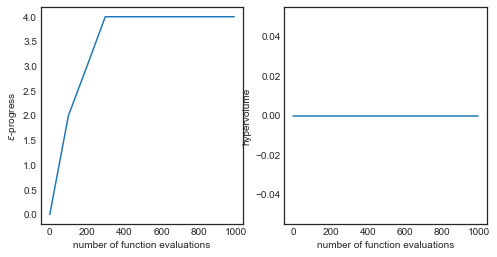

In [170]:
# Check convergence
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_moro.nfe, convergence_moro.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_moro.nfe, convergence_moro.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

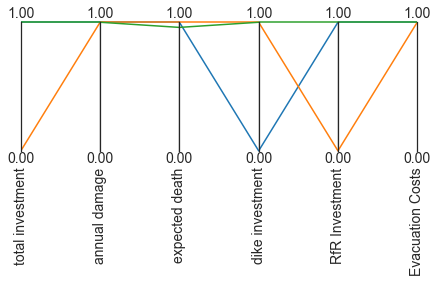

In [236]:
# Checking the trade off in terms of robustness score
from ema_workbench.analysis import parcoords

data = archive_moro.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

# Scenario Discovery - to find good trigger for adaptive policies (if timeframe included)

In [184]:
policies_moro = [Policy("policy_1", **archive_moro.to_dict('records')[0]),   # the three policies, as found from MORO (see above)
             Policy("policy_2", **archive_moro.to_dict('records')[1]),
             Policy("policy_3", **archive_moro.to_dict('records')[2])]

In [188]:
n_scenarios_moro_open = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_moro_open = evaluator.perform_experiments(n_scenarios_moro_open, policies_moro)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [190]:
experiments_open, outcomes_open = results_moro_open

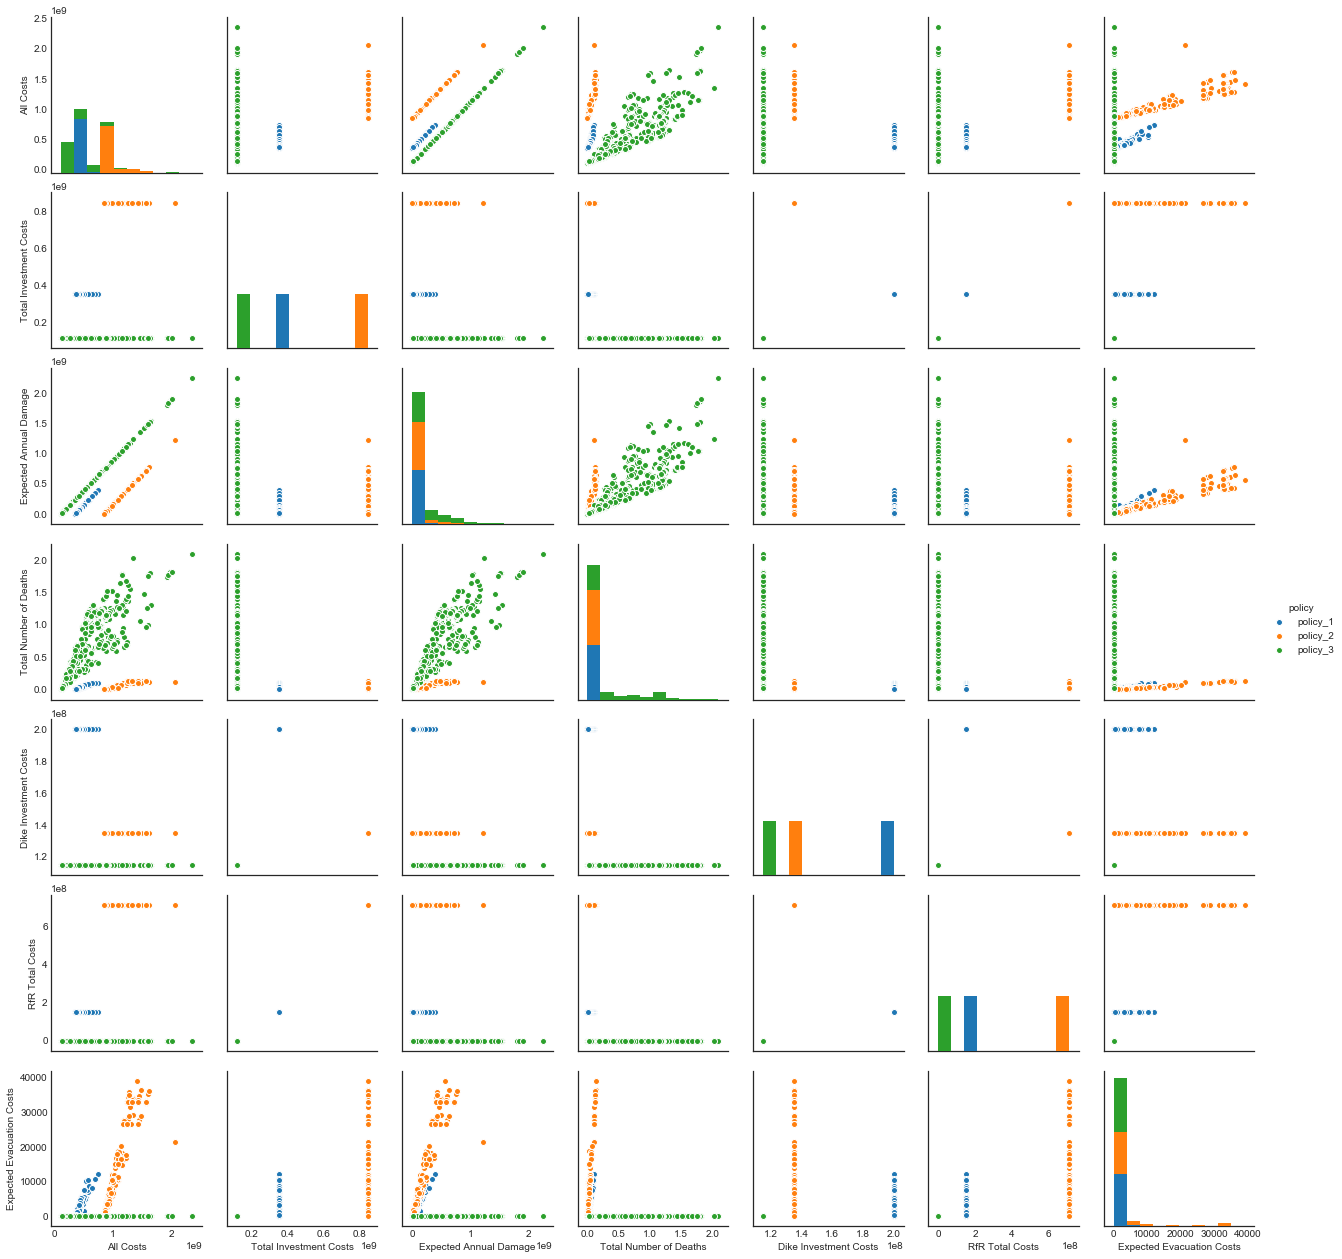

In [192]:
# Open exploration to examine the policies

# Show in dimensional stacking
df = pd.DataFrame.from_dict(outcomes_open)
df = df.assign(policy=experiments_open['policy'])
 
# use seaborn to plot the dataframe
grid = sns.pairplot(df, hue='policy', vars=outcomes_open.keys())
ax = plt.gca()
plt.show();

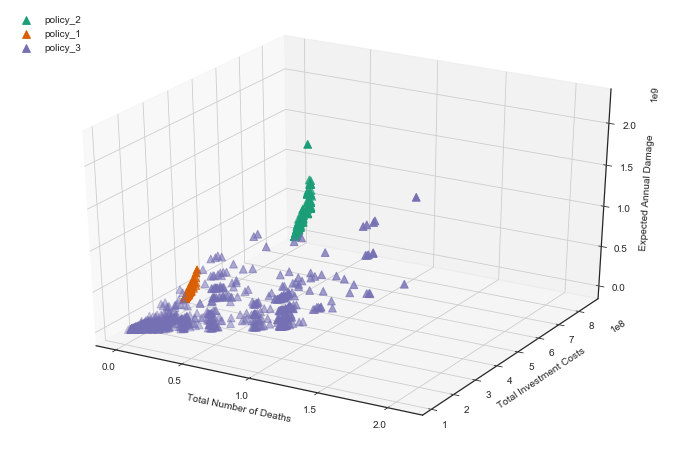

In [193]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette('Dark2', 3)
markers = ['o', '^']
oois = ['Total Number of Deaths', 'Total Investment Costs','Expected Annual Damage']

ax.set_xlabel(oois[0])
ax.set_ylabel(oois[1])
ax.set_zlabel(oois[2])

for p, policy in enumerate(set(experiments_open['policy'])):
    logical = experiments_open['policy']==policy
    new_outcomes = {key:value[logical] for key, value in outcomes_open.items()}
    new_experiments = experiments_open[logical]
    
    #logical_index = (new_outcomes['infected fraction R1'][:, 99]>0.1) &\
     #               (new_experiments['infection ratio region 1']>0.1)
    
    #x_ = new_outcomes[oois[0]][logical_index]
    x = new_outcomes[oois[0]]
    
    #y_ = new_outcomes[oois[1]][logical_index,-1]
    y = new_outcomes[oois[1]]
    
    #z_ = new_outcomes[oois[2]][logical_index]
    z = new_outcomes[oois[2]]
    
    ax.scatter(x, y, z, c=colors[p], marker=markers[1], s=60, label=policy)
    #ax.scatter(x_, y_, z_, c=colors[p], marker=markers[1], s=60, label=policy+'***')

ax.legend(loc=2, scatterpoints = 1)
#ax.set_xlim([0, 0.5])
#ax.set_ylim([0, 5e+07])
#ax.set_zlim([0, 50])
fig.set_figheight(8)
fig.set_figwidth(12)

plt.show()

In [194]:
grid.savefig("Correlation_plot.PNG")
fig.savefig("3D_plot.PNG")

In [202]:
lever_names_open = [l.name for l in dike_model.levers]
experiments_open_2 = rf.drop_fields(experiments_open, drop_names=lever_names_open+['policy'], 
                             asrecarray=True)

In [213]:
# (continue) Scenario discovery
x = experiments_open_2
y = outcomes_open['Total Number of Deaths'] >= np.percentile(outcomes_open['Total Number of Deaths'], 75)

prim_alg = prim.Prim(x,y, threshold=0.66)
box1 = prim_alg.find_box()

[MainProcess/INFO] 3000 points remaining, containing 750 cases of interest
[MainProcess/INFO] mean: 0.6666666666666666, mass: 0.064, coverage: 0.17066666666666666, density: 0.6666666666666666 restricted_dimensions: 2


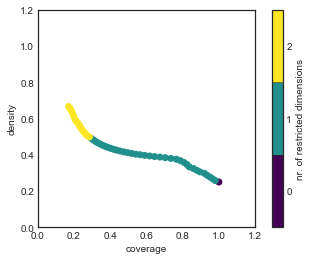

In [214]:
box1.show_tradeoff()
plt.show()

In [215]:
box1.inspect()

coverage    0.170667
density     0.666667
mass           0.064
mean        0.666667
res dim            2
Name: 51, dtype: object

             box 51                                     
                min         max                qp values
A.3_pfail  0.000723    0.063626  [1.552015713536159e-33]
A.3_Bmax   5.072591  375.994949     [0.5338635681694446]



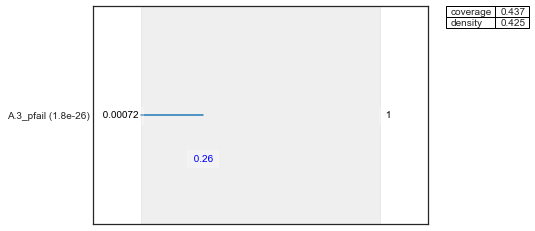

In [220]:
box1.inspect(26, style='graph')
plt.show()

In [226]:
x_2 = experiments_open_2
y_2 = outcomes_open['Expected Annual Damage'] >= np.percentile(outcomes_open['Expected Annual Damage'], 75)

prim_alg_2 = prim.Prim(x_2,y_2, threshold=0.68)
box2 = prim_alg_2.find_box()

[MainProcess/INFO] 3000 points remaining, containing 750 cases of interest
[MainProcess/INFO] mean: 0.6862745098039216, mass: 0.051, coverage: 0.14, density: 0.6862745098039216 restricted_dimensions: 2


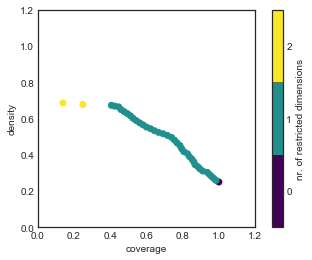

In [227]:
box2.show_tradeoff()
plt.show()

In [228]:
box2.inspect()

coverage        0.14
density     0.686275
mass           0.051
mean        0.686275
res dim            2
Name: 38, dtype: object

                box 38                                    
                   min       max                 qp values
A.3_pfail  0.000722638  0.151247  [1.9319493819788445e-30]
A.4_Brate        {0.9}     {0.9}     [0.40253668204635606]



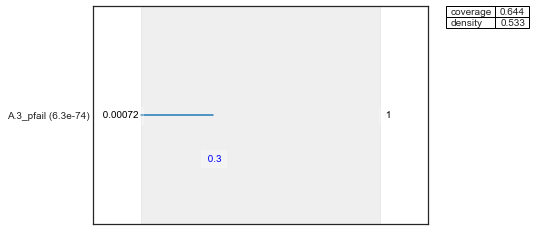

In [235]:
box2.inspect(23, style='graph')
plt.show()